## Lagrangian Neural Networks

Tutorial: https://colab.research.google.com/drive/1CSy-xfrnTX28p1difoTA8ulYw0zytJkq#scrollTo=9q6Od6KqZemA

In [9]:
import numpy as np
import seaborn as sns
from HenonHeiles import *
from tqdm import trange
import datetime

import jax
import jax.numpy as jnp
import numpy as np
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
from functools import partial # reduces arguments to function by making some subset implicit
from jax.example_libraries import stax
from jax.example_libraries import optimizers

# visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from moviepy.editor import ImageSequenceClip
from functools import partial
import proglog
from PIL import Image


#Debugging nan values
jax.config.update("jax_debug_nans", True)

np.random.seed(33)

plt.rcParams['font.size'] = 12
plt.rcParams['lines.markersize'] = 10
plt.rcParams['legend.fontsize'] = 10
colors = sns.color_palette([(0.6,0.8,.8), (1,0.7,0.3), (0.2,0.7,0.2), (0.8,0,0.2), (0,0.4,1), (0.6,0.5,.9), (0.5,0.3,.5)])

In [10]:
def Lagrangian(q,q_dot,lam=1):
    x,y = q
    px,py = q_dot
    K = 0.5*(px**2+py**2)
    V = 0.5*(x**2+y**2)+lam*(x**2*y-1/3*y**3)
    L = K-V

    return L

In [11]:
def f_analytical(u,lam=1):
    if u.ndim ==1:
        x,y,px,py = u[0],u[1],u[2],u[3]
    else:
        x,y,px,py = u[:,0],u[:,1],u[:,2],u[:,3]
    f = jnp.stack([px,py,-x-2*lam*x*y,-y-lam*(x**2-y**2)])
  
    return f

### Deriving q_tt for Euler-Lagrange
$$
\begin{align}
\frac{d}{dt} \frac{\partial \mathcal{L}}{\partial \dot q_j} &= \frac{\partial \mathcal{L}}{\partial q_j} & \text{write down the Euler-Lagrange equation} \quad (1)\\
\frac{d}{dt} \nabla_{\dot q} \mathcal{L} &= \nabla_{q} \mathcal{L} & \text{switch to vector notation} \quad (2)\\
(\nabla_{\dot q}\nabla_{\dot q}^{\top}\mathcal{L})\ddot q + (\nabla_{q}\nabla_{\dot q}^{\top}\mathcal{L}) \dot q &= \nabla_q \mathcal{L} & \text{expand the time derivative }\frac{d}{dt} \quad (3)\\
\ddot q &= (\nabla_{\dot q}\nabla_{\dot q}^{\top}\mathcal{L})^{-1}[\nabla_q \mathcal{L} - (\nabla_{q}\nabla_{\dot q}^{\top}\mathcal{L})\dot q] & \text{use a matrix inverse to solve for } \ddot q \quad (4)\\
\end{align}
$$

In [12]:
def Equation_of_motion(Lagrangian,u, t = None):
  #print("u shape: " +str(u.shape))
  #print("u : " +str(u))
  q, q_t = jnp.split(u, 2,axis=-1)
  q_tt = (jnp.linalg.pinv(jax.hessian(Lagrangian, 1)(q, q_t)) @ (jax.grad(Lagrangian, 0)(q, q_t) - jax.jacobian(jax.jacobian(Lagrangian, 1), 0)(q, q_t) @ q_t))

  return jnp.concatenate([q_t,q_tt],axis=-1)


def Solve_Lagrangian(Lagrangian, u0,**kwargs):
  @partial(jax.jit, backend='cpu')
  def f(u0):
    sol = odeint(partial(Equation_of_motion, Lagrangian),u0, **kwargs)
    return sol

  return f(u0)


In [13]:
# Henon-Heiles dynamics via the rewritten Euler-Lagrange
@partial(jax.jit, backend='cpu')
def solve_autograd(u0, times):
  L = partial(Lagrangian)
  #print("solve_autograd L NaN check:", jnp.bool(jnp.any(jnp.isnan(L))).any())
  sol = Solve_Lagrangian(L, u0, t=times, rtol=1e-10, atol=1e-10)
  #print("solve_autograd sol NaN check:", bool(jnp.any(jnp.isnan(sol))).any())
  return sol

# Henon-Heiles dynamics via analytical forces 
#@partial(jax.jit, backend='cpu')
def solve_analytical(u0, times):
  sol = odeint(f_analytical, u0, t=times, rtol=1e-10, atol=1e-10)
  return sol


def normalize_dp(state):
  # wrap generalized coordinates to [-pi, pi]
  dp = jnp.concatenate([(state[:2] + np.pi) % (2 * np.pi) - np.pi, state[2:]])
  #print("normalize_dp NaN check:", bool(jnp.any(jnp.isnan(dp))).any())
  return dp

def rk4_step(f, x, t, h):
  # one step of runge-kutta integration
  k1 = h * f(x, t)
  k2 = h * f(x + k1/2, t + h/2)
  k3 = h * f(x + k2/2, t + h/2)
  k4 = h * f(x + k3, t + h)
  sol = x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)
  #print("RK4 NaN check:", bool(jnp.any(jnp.isnan(sol))).any())
  return sol

    
def explicit_midpoint_step(f,x,t,h):
    x = x +h*f(x+h/2*f(t,x),t+h/2)
    return x
   


def symplectic_euler_step(f,x,t,h):
   g = f(x,t)
   z = f(x+h*f(x,t),t)
   
   return x

def symplectic_euler(u_dot,u_start,dt):
    g = u_dot(u_start)
    f = u_dot(u_start+u_dot(u_start)*dt)
    if isinstance(u_start,torch.Tensor):
        if u_start.ndim == 1:
            rhs = torch.cat((f[0:2], g[2:4]))
        else:
            rhs = torch.cat((f[:,0:2],g[:,2:4]),axis = 1)
    else:
        rhs = np.concatenate((f[0:2], g[2:4]))
    return rhs

In [14]:
def initial_condition(H0=None,lam=1):
    """Function for sampling initial conditions. Callabale taking
        a numpy random generator as input and returning an ndarray
        of shape (nstates,) with inital conditions for the system."""
    x0= 0
    if H0 is None:
        H0 = np.random.uniform(0,1/10)
    while True:
        y0 = np.random.uniform(-1,1)    
        py0 = np.random.uniform(-1,1)
        K = 2*H0-(py0**2 +y0**2-lam/3*y0**3)
        if K>= 0:
            break
    px0 = np.sqrt(K)
    return np.array([x0,y0,px0,py0]).flatten()

In [15]:
def generate_data(sys,ntrajectories,nsamples,T_max,u0s=None):
    dt = T_max/nsamples
    nt = round(T_max / dt)
    t = np.linspace(0, T_max, nt + 1,dtype=np.float32)

    analytical_step = jax.jit(jax.vmap(partial(rk4_step, f_analytical, t=0.0, h=dt)))

    if u0s == None:
        u0s = np.zeros((ntrajectories,sys.nstates))
        for i in range(ntrajectories):
            u0s[i] = initial_condition()

    u = np.zeros((ntrajectories,nsamples+1,sys.nstates))
    dudt = np.zeros_like(u)
    y = np.zeros_like(u)

    for i in range(ntrajectories):
        u[i] = jax.device_get(solve_analytical(u0s[i], t))
        dudt[i] = jax.device_get(jax.vmap(f_analytical)(u[i])) 
        y[i] = jax.device_get(analytical_step(u[i]))

    return u,dudt,y,dt

## Lagrangian Neural Network

In [16]:
# replace the lagrangian with a parameteric model
def learned_lagrangian(params):
  def lagrangian(q, q_t):
    #print("q shape: " +str(q.shape))
    #print("q: " +str(q))
    #print("q_t shape: " +str(q_t.shape))
    #print("q_t: " +str(q_t))
    #assert q.shape == (2,)
    assert q.shape[-1] == 2 
    #state = normalize_dp(jnp.concatenate([q, q_t]))
    state = normalize_dp(jnp.concatenate([q, q_t], axis=-1))
   
    forw = jnp.squeeze(nn_forward_fn(params, state), axis=-1)

    return forw
  return lagrangian
# define the loss of the model (MSE between predicted q, \dot q and targets)
@jax.jit
def loss(params, batch, time_step=None):
  state, targets = batch
  f = partial(Equation_of_motion, learned_lagrangian(params))
  if time_step is not None:
    #preds = jax.vmap(partial(rk4_step, f, t=0.0, h=time_step))(state)
    preds = jax.vmap(jax.vmap(partial(rk4_step, f, t=0.0, h=time_step)))(state)

  else:
    #preds = jax.vmap(partial(Equation_of_motion, learned_lagrangian(params)))(state)
    preds = jax.vmap(jax.vmap(f))(state)

  sol = jnp.mean((preds - targets) ** 2)

  return sol

# build a neural network model
init_random_params, nn_forward_fn = stax.serial(
    stax.Dense(128),
    stax.Softplus,
    stax.Dense(128),
    stax.Softplus,
    stax.Dense(1),
)

@jax.jit
def update_timestep(i, opt_state, batch,dt):
  params = get_params(opt_state)

  upd = opt_update(i, jax.grad(loss)(params, batch, dt), opt_state)

  return upd

@jax.jit
def update_derivative(i, opt_state, batch):
  params = get_params(opt_state)

  upd = opt_update(i, jax.grad(loss)(params, batch, None), opt_state)

  return upd




In [17]:
"""
%%time

rng = jax.random.PRNGKey(0)
_, init_params = init_random_params(rng, (-1, 4))

# numbers in comments denote stephan's settings
batch_size = 10
test_every = 1
num_batches = 150

train_losses = []
test_losses = []

# adam w learn rate decay
opt_init, opt_update, get_params = optimizers.adam(
    lambda t: jnp.select([t < batch_size*(num_batches//3),
                          t < batch_size*(2*num_batches//3),
                          t > batch_size*(2*num_batches//3)],
                         [1e-3, 3e-4, 1e-4]))
opt_state = opt_init(init_params)

for iteration in range(batch_size*num_batches + 1):
  if iteration % batch_size == 0:
    params = get_params(opt_state)
    #print("params: " +str(params))

    train_loss = loss(params, (u_train, ut_train))
    train_losses.append(train_loss)
    test_loss = loss(params, (u_test, ut_test))
    test_losses.append(test_loss)

    print(f"iteration={iteration}, train_loss={train_loss:.6f}, test_loss={test_loss:.6f}")
  opt_state = update_derivative(iteration, opt_state, (u_train, ut_train))

params = get_params(opt_state)"
"""

'\n%%time\n\nrng = jax.random.PRNGKey(0)\n_, init_params = init_random_params(rng, (-1, 4))\n\n# numbers in comments denote stephan\'s settings\nbatch_size = 10\ntest_every = 1\nnum_batches = 150\n\ntrain_losses = []\ntest_losses = []\n\n# adam w learn rate decay\nopt_init, opt_update, get_params = optimizers.adam(\n    lambda t: jnp.select([t < batch_size*(num_batches//3),\n                          t < batch_size*(2*num_batches//3),\n                          t > batch_size*(2*num_batches//3)],\n                         [1e-3, 3e-4, 1e-4]))\nopt_state = opt_init(init_params)\n\nfor iteration in range(batch_size*num_batches + 1):\n  if iteration % batch_size == 0:\n    params = get_params(opt_state)\n    #print("params: " +str(params))\n\n    train_loss = loss(params, (u_train, ut_train))\n    train_losses.append(train_loss)\n    test_loss = loss(params, (u_test, ut_test))\n    test_losses.append(test_loss)\n\n    print(f"iteration={iteration}, train_loss={train_loss:.6f}, test_loss={

In [38]:


def train(traindata,valdata, batch_size,num_batches, verbose =True,batch=True):



    u_train, ut_train = traindata
    if valdata is not None:
        u_val, ut_val = valdata

    rng = jax.random.PRNGKey(0)
    _, init_params = init_random_params(rng, (-1, 4))

    trainingdetails={}

    loss_list = []
    val_loss_list =  []

    epochs = batch_size*num_batches + 1

    opt_state = opt_init(init_params)

    with trange(epochs) as steps:
        for epoch in steps:
            #if epoch % batch_size == 0:
            params = get_params(opt_state)
            #print("params: " +str(params))
            start = datetime.datetime.now() 
            train_loss = loss(params, (u_train, ut_train))
            end = datetime.datetime.now() 
            loss_list.append(train_loss)
    
            if verbose: #Print
                steps.set_postfix(epoch=epoch, loss=train_loss)
            if valdata is not None:
                start = datetime.datetime.now()
                val_loss = loss(params, (u_val, ut_val))
                end = datetime.datetime.now()
                val_loss_list.append(val_loss)
                


            opt_state = update_derivative(epoch, opt_state, (u_train, ut_train))

            trainingdetails["epochs"] = epoch + 1
            trainingdetails["train_loss"] = loss_list
   

    params = get_params(opt_state)
     # Plot the loss curve
    plt.figure(figsize=(7, 4))
    plt.plot(loss_list, label = "Training Loss")
    if valdata is not None:
        plt.plot(val_loss_list,label = "Validation Loss")
    plt.legend()
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    return trainingdetails


In [46]:


def Batch_Data(u_train, ut_train, batch_size):
    """
    Splits the training data into trajectory-based batches.
    
    Args:
        u_train (jax.numpy.ndarray): Input training data of shape (ntraj, nsample, 4)
        ut_train (jax.numpy.ndarray): Target training data of shape (ntraj, nsample, 4)
        batch_size (int): Number of trajectories per batch
    
    Returns:
        Generator that yields batches of (u_batch, ut_batch) with shape (batch_size, nsample, 4)
    """
    ntraj, nsample, _ = u_train.shape
    
    def batch_generator():
        for i in range(0, ntraj, batch_size):
            yield u_train[i:i + batch_size], ut_train[i:i + batch_size]
    
    return batch_generator()

In [ ]:
def train_one_epoch():
    batch_generator = Batch_Data(u_train, ut_train, batch_size)  # Get a new batch generator
    loss_list
    for u_batch, ut_batch in batch_generator:
        params = get_params(opt_state)
        train_loss = loss(params, (u_batch, ut_batch))  # Compute loss on batch
        loss_list.append(train_loss)

        opt_state = update_derivative(epoch, opt_state, (u_batch, ut_batch))  # Update with batch

In [43]:
def train(traindata, valdata, batch_size, num_batches, verbose=True, batch=True):
    u_train, ut_train = traindata
    if valdata is not None:
        u_val, ut_val = valdata

    rng = jax.random.PRNGKey(0)
    _, init_params = init_random_params(rng, (-1, 4))

    trainingdetails = {}
    loss_list = []
    val_loss_list = []

    opt_state = opt_init(init_params)

    with trange(num_batches) as steps:
        for epoch in steps:
            batch_generator = Batch_Data(u_train, ut_train, batch_size)  # Get a new batch generator
            
            for u_batch, ut_batch in batch_generator:
                params = get_params(opt_state)
                train_loss = loss(params, (u_batch, ut_batch))  # Compute loss on batch
                loss_list.append(train_loss)

                if verbose:
                    steps.set_postfix(epoch=epoch, loss=train_loss)
                
                if valdata is not None:
                    val_loss = loss(params, (u_val, ut_val))  # Validation on full dataset
                    val_loss_list.append(val_loss)

                opt_state = update_derivative(epoch, opt_state, (u_batch, ut_batch))  # Update with batch

            trainingdetails["epochs"] = epoch + 1
            trainingdetails["train_loss"] = loss_list

    params = get_params(opt_state)

    # Plot the loss curve
    plt.figure(figsize=(7, 4))
    plt.plot(loss_list, label="Training Loss")
    if valdata is not None:
        plt.plot(val_loss_list, label="Validation Loss")
    plt.legend()
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    return trainingdetails, params


In [44]:
T_max_train = 2
nsamples_train = 100
ntraj_train = 2000

T_max_test = T_max_train
nsamples_test = nsamples_train
ntraj_test = 750


sys = HenonHeilesSystem()

u_train,ut_train,y_train, dt_train = generate_data(sys=sys,ntrajectories=ntraj_train,nsamples=nsamples_train,T_max=T_max_train,u0s=None)
u_test,ut_test,y_test,dt_test = generate_data(sys=sys,ntrajectories=ntraj_test,nsamples=nsamples_test,T_max=T_max_test,u0s=None)


u_train = jax.device_put(jax.vmap(normalize_dp)(u_train))
y_train = jax.device_put(y_train)

u_test = jax.device_put(jax.vmap(normalize_dp)(u_test))
y_test = jax.device_put(y_test)

100%|██████████| 30/30 [01:32<00:00,  3.09s/it, epoch=29, loss=0.0047606784]


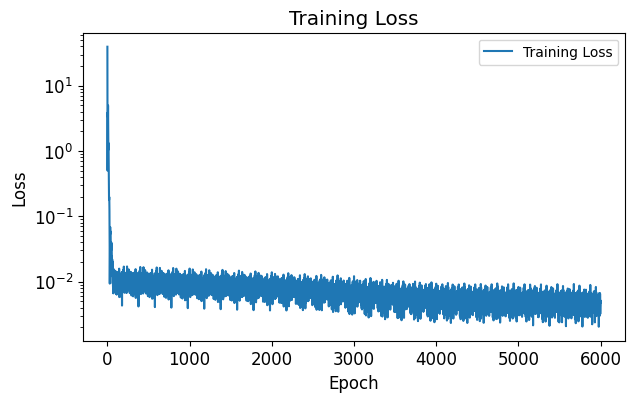

In [47]:
traindata = (u_train, ut_train)
valdata = (u_test, ut_test)

batch_size = 10
num_batches = 30

# adam w learn rate decay
opt_init, opt_update, get_params = optimizers.adam(
    lambda t: jnp.select([t < batch_size*(num_batches//3),
                        t < batch_size*(2*num_batches//3),
                        t > batch_size*(2*num_batches//3)],
                        [1e-3, 3e-4, 1e-4]))


trainingdetails,params = train(traindata=traindata,valdata=None, batch_size=batch_size,num_batches=num_batches, verbose =True)

In [42]:

ut_pred = jax.vmap(partial(Equation_of_motion, learned_lagrangian(params)))(u_test)

fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=120)
axes[0].scatter(ut_test[:, 2], ut_pred[:, 2], s=6, alpha=0.2)
axes[0].set_title('Predicting $\dot q$')
axes[0].set_xlabel('$\dot q$ actual')
axes[0].set_ylabel('$\dot q$ predicted')
axes[1].scatter(ut_test[:, 3], ut_pred[:, 3], s=6, alpha=0.2)
axes[1].set_title('Predicting $\ddot q$')
axes[1].set_xlabel('$\ddot q$ actual')
axes[1].set_ylabel('$\ddot q$ predicted')
plt.tight_layout()

NameError: name 'opt_state' is not defined

In [ ]:
"""
def find_nan(arr):

    # Find indices where NaN values are present
    nan_indices = jnp.where(jnp.isnan(arr))

    # Convert to a list of (i, j, k) index tuples
    nan_indices_list = list(zip(*[arr.tolist() for arr in nan_indices]))

    print(f"Total NaN values found: {len(nan_indices_list)}")
    print(f"Indices of NaN values: {nan_indices_list}")


for arr in [u_train,ut_train,y_train,u_test,ut_test,y_test]:
    find_nan(arr)

i = 0
train_vis = jax.vmap(normalize_dp)(u_train[i])
test_vis = jax.vmap(normalize_dp)(u_test[i])

vel_angle = lambda data:  (np.arctan2(data[:,3], data[:,2]) / np.pi + 1)/2
vel_color = lambda vangle: np.stack( [np.zeros_like(vangle), vangle, 1-vangle]).T
train_colors = vel_color(vel_angle(train_vis))
test_colors = vel_color(vel_angle(test_vis))

# plot
SCALE = 80 ; WIDTH = 0.006
plt.figure(figsize=[8,4], dpi=120)
plt.subplot(1,2,1)
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
plt.title("Train data") ; plt.xlabel(r'$\theta_1$') ; plt.ylabel(r'$\theta_2$')
plt.quiver(*train_vis.T, color=train_colors, scale=SCALE, width=WIDTH)

plt.subplot(1,2,2)
plt.title("Test data") ; plt.xlabel(r'$\theta_1$') ; plt.ylabel(r'$\theta_2$')
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
plt.quiver(*test_vis.T, color=test_colors, scale=SCALE, width=WIDTH)

plt.tight_layout() ; plt.show()"
"""